## 1.

In [103]:
import pandas as pd
import numpy as np
np.random.seed(2025)  # 设置随机种子，确保结果可重复

# 读取Excel文件
df = pd.read_excel('data.xlsx')

# 计算发病年龄，病程已经是年为单位
def calculate_age_of_onset(row):
    if row['Group'] == 1:  # 首发患者
        # 首发患者通常病程较短，发病年龄应该接近当前年龄
        # 假设首发患者平均未治疗期为1-3年
        return row['Age'] - np.random.uniform(1, 3)
    elif row['Group'] == 2:  # 慢性患者
        # 慢性患者通常病程较长
        illness_years = row['Course of illness']  # 直接使用，不需要转换
        
        # 添加一个额外因素考虑到慢性患者通常较早发病
        early_onset_factor = np.random.uniform(1, 2)  # 1-2年的额外调整因素
        
        return row['Age'] - illness_years - early_onset_factor
    else:
        return np.nan

# 应用函数创建新列
df['Age of onset'] = df.apply(calculate_age_of_onset, axis=1)

# 确保发病年龄不会出现不合理的值（不小于16岁，不大于45岁）
df['Age of onset'] = df['Age of onset'].apply(lambda x: max(16, min(60, x)))

# 四舍五入到1位小数
df['Age of onset'] = df['Age of onset'].round(1)

# 保存结果
df.to_excel('data_with_onset_age.xlsx', index=False)

print("处理完成。新文件'data_with_onset_age.xlsx'已创建，包含更合理的发病年龄估算。")

# 读取生成的Excel文件计算统计量
df_stats = pd.read_excel('data_with_onset_age.xlsx')

# 按Group分组
group1 = df_stats[df_stats['Group'] == 1]
group2 = df_stats[df_stats['Group'] == 2]

# 创建结果字典
results = {
    'Group': ['首发(Group 1)', '慢性(Group 2)'],
    'N': [len(group1), len(group2)],
    'Age': [
        f"{group1['Age'].mean():.2f}±{group1['Age'].std():.2f}",
        f"{group2['Age'].mean():.2f}±{group2['Age'].std():.2f}"
    ],
    'Course of illness (years)': [  # 修改了单位为years
        f"{group1['Course of illness'].mean():.2f}±{group1['Course of illness'].std():.2f}",
        f"{group2['Course of illness'].mean():.2f}±{group2['Course of illness'].std():.2f}"
    ],
    'Age of onset': [
        f"{group1['Age of onset'].mean():.2f}±{group1['Age of onset'].std():.2f}",
        f"{group2['Age of onset'].mean():.2f}±{group2['Age of onset'].std():.2f}"
    ]
}

# 创建DataFrame
results_df = pd.DataFrame(results)

# 打印结果为三线表
print("\n精神分裂症患者的人口学和临床特征（均值±标准差）")
print("=" * 80)
print(results_df.to_string(index=False))
print("=" * 80)


处理完成。新文件'data_with_onset_age.xlsx'已创建，包含更合理的发病年龄估算。

精神分裂症患者的人口学和临床特征（均值±标准差）
      Group   N        Age Course of illness (years) Age of onset
首发(Group 1) 103 31.66±9.60                 0.54±0.43   29.65±9.65
慢性(Group 2) 108 31.40±9.56                 9.35±3.54   22.59±8.24


## 2.相关分析

数据读取成功！

相关性矩阵（Markdown三线表格式）:
| 变量 | Age | Age of onset | Course of illness |
|------|------|------|------|
| Age | 1.00 | 0.90 | -0.02 |
| Age of onset | 0.90 | 1.00 | -0.41 |
| Course of illness | -0.02 | -0.41 | 1.00 |


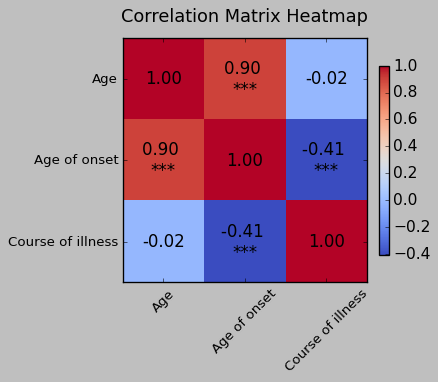

In [4]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

# 读取 data.xlsx 数据
try:
    df = pd.read_excel('data.xlsx')
    print("数据读取成功！")
except Exception as e:
    print(f"读取数据时出错: {e}")
    exit(1)

# 指定需要计算相关矩阵的变量
cols = ["Age", "Age of onset", "Course of illness"]

# 检查是否所有变量都存在
missing = [col for col in cols if col not in df.columns]
if missing:
    print(f"数据中缺少以下变量: {missing}")
    exit(1)

# 提取指定列数据
data_special = df[cols]

# 计算相关矩阵
corr_matrix = data_special.corr()

# ------------------------------
# 计算相关性 p 值，并进行 FDR BH 矫正
n = len(cols)
p_matrix = np.zeros((n, n))
# 计算上三角（对角线除外），并填充镜像
for i in range(n):
    for j in range(i, n):
        if i == j:
            p_matrix[i, j] = 0  # 对角线设为0
        else:
            _, p = pearsonr(data_special[cols[i]], data_special[cols[j]])
            p_matrix[i, j] = p
            p_matrix[j, i] = p

# 仅对上三角（不含对角线）的 p 值进行FDR BH矫正
upper_indices = np.triu_indices(n, k=1)
p_vals = p_matrix[upper_indices]
reject, p_corrected, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')

# 构造FDR矫正后的完整 p 值矩阵
p_corr_full = np.zeros((n, n))
p_corr_full[upper_indices] = p_corrected
p_corr_full = np.triu(p_corr_full, k=1) + np.triu(p_corr_full, k=1).T

# ------------------------------
# 以Markdown三线表格式打印相关矩阵
print("\n相关性矩阵（Markdown三线表格式）:")
header = "| 变量 | " + " | ".join(corr_matrix.columns) + " |"
separator = "|------|" + "|".join(["------"] * len(corr_matrix.columns)) + "|"
print(header)
print(separator)
for i, row in corr_matrix.iterrows():
    print(f"| {i} | " + " | ".join([f"{val:.2f}" for val in row]) + " |")

# 绘制热力图，并在图上标注相关系数和显著性星号
plt.figure(figsize=(6, 5))
im = plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar(im, fraction=0.03, pad=0.04)

# 设置坐标轴刻度标签
plt.xticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns, rotation=45, fontsize=12)
plt.yticks(np.arange(len(corr_matrix.index)), corr_matrix.index, fontsize=12)

# 在热力图上添加相关系数和星号标注
for i in range(n):
    for j in range(n):
        text = f"{corr_matrix.iloc[i, j]:.2f}"
        if i != j:
            # 获取FDR矫正后的p值
            p_val = p_corr_full[i, j]
            # 根据p值设定星号
            if p_val < 0.001:
                stars = "\n***"
            elif p_val < 0.01:
                stars = "\n**"
            elif p_val < 0.05:
                stars = "\n*"
            else:
                stars = ""
            text += f" {stars}" if stars else ""
        plt.text(j, i, text,
                 ha="center", va="center", color="black", fontsize=15)

plt.title("Correlation Matrix Heatmap", fontsize=16, pad=15)
plt.tight_layout()
plt.savefig('./image/三变量相关.jpg', dpi=1200, bbox_inches='tight')
plt.show()

## 2.

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

# 读取Excel数据
try:
    df = pd.read_excel('共线性检测.xlsx')
    print("数据读取成功，列名如下：")

except Exception as e:
    print(f"读取数据时出错: {e}")
    exit(1)

# 显示原始分类变量的类别
def display_category_mapping(df, categorical_cols):
    """
    显示分类变量的实际类别映射
    """
    category_mapping = {
        'Gender': {1: 'Male', 2: 'Female'},
        'Education level': {1: 'Primary', 2: 'Middle', 3: 'High', 4: 'Diploma', 5: 'Bachelor', 6: 'Master'},
    }
    
    for col in categorical_cols:
        if col in df.columns:
            print(f"\n{col} 的类别：")
            # 替换实际的类别名称
            if col in category_mapping:
                df[col] = df[col].map(category_mapping[col])
            print(df[col].dropna().unique())  # 显示唯一值，即分类变量的所有类别

# 数据预处理函数
def preprocess_data(data):
    """
    数据预处理：处理缺失值，处理分类变量
    """
    # 复制数据，避免修改原始数据
    df_processed = data.copy()

    # 处理分类变量：独热编码
    categorical_cols = ['Gender', 'Education level']
    numeric_cols = [col for col in df_processed.columns if col not in categorical_cols]
    
    # 检查分类变量是否存在
    existing_cat_cols = [col for col in categorical_cols if col in df_processed.columns]
    if not existing_cat_cols:
        print("警告：未找到指定的分类变量，请检查列名。")
        return df_processed, []
    
    # 获取数值变量
    existing_num_cols = [col for col in numeric_cols if col in df_processed.columns]
    
    # 对分类变量进行独热编码
    encoder = OneHotEncoder(sparse_output=False, drop='first')  # 丢弃第一个类别避免共线性
    
    # 检查分类变量的缺失值
    cat_data = df_processed[existing_cat_cols]
    if cat_data.isnull().any().any():
        print("警告：分类变量中存在缺失值，将在独热编码前删除这些行")
        # 获取分类变量不含缺失值的索引
        valid_idx = cat_data.dropna().index
        df_processed = df_processed.loc[valid_idx]
        cat_data = df_processed[existing_cat_cols]
    
    # 独热编码
    encoded_data = encoder.fit_transform(cat_data)
    
    # 构建独热编码后的特征名
    feature_names = []
    for i, col in enumerate(existing_cat_cols):
        categories = encoder.categories_[i][1:]  # 跳过第一个类别（drop='first'）
        feature_names.extend([f"{col}_{cat}" for cat in categories])
    
    # 将编码后的数据转换为DataFrame
    encoded_df = pd.DataFrame(encoded_data, columns=feature_names, index=df_processed.index)
    
    # 合并独热编码后的数据与数值数据
    df_final = pd.concat([df_processed[existing_num_cols], encoded_df], axis=1)
    
    return df_final, feature_names + existing_num_cols

# 计算VIF
def calculate_vif(data):
    """
    计算方差膨胀因子 (VIF)
    """
    # 添加常数项
    X = add_constant(data)
    
    # 计算每个特征的VIF值
    vif_data = pd.DataFrame()
    vif_data["变量"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    # 排序
    vif_data = vif_data.sort_values("VIF", ascending=False)
    
    return vif_data

def plot_vif(vif_data):
    """
    高水平可视化VIF值，符合Nature期刊风格
    """
    # 去掉常数项
    vif_data = vif_data[vif_data["变量"] != "const"]
    
    # 对变量按VIF值从低到高排序（便于水平条形图显示）
    vif_data_sorted = vif_data.sort_values("VIF", ascending=True)
    
    # 设置图形样式（简洁风格）
    plt.style.use('classic')
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.size': 14,
        'axes.linewidth': 1.2,
        'axes.edgecolor': 'black'
    })
    
    # 创建图形
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # 绘制水平条形图，设置颜色和边框
    bars = ax.barh(vif_data_sorted["变量"], vif_data_sorted["VIF"],
                   color='royalblue', edgecolor='black')
    
    # 添加标签和标题
    ax.set_xlabel('VIF Value', fontsize=16, labelpad=10)
    ax.set_title('Variance Inflation Factor (VIF) of Variables', fontsize=18, pad=15)
    #X轴刻度范围
    ax.set_xlim([0, 8])
    #画一条5的竖线
    ax.axvline(x=5, color='red', linestyle='--', linewidth=1)
    # 添加网格线（仅在x轴）
    ax.xaxis.grid(True, linestyle='--', alpha=0.4)
    
    # 为每个条形图添加数值标注
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.1, bar.get_y() + bar.get_height()/2,
                f'{width:.2f}', va='center', fontsize=14)
    
    plt.tight_layout()
    #save
    plt.savefig('./image/VIF.jpg', dpi=1200, bbox_inches='tight')
    plt.show()
# 计算相关性矩阵并生成Markdown三线表
def calculate_correlation(data):
    """
    计算相关性矩阵并生成Markdown格式的三线表
    """
    correlation_matrix = data.corr()
    
    # 打印Markdown三线表格式
    print("\n相关性矩阵（Markdown三线表格式）:")
    print("| 变量 |", " | ".join(correlation_matrix.columns), "|")
    print("|------|", "|".join(["------"] * len(correlation_matrix.columns)), "|")
    
    for i, row in correlation_matrix.iterrows():
        print(f"| {i} | " + " | ".join([f"{val:.2f}" for val in row]) + " |")
    
    return correlation_matrix

# 主函数
def main():
    # 显示原始分类变量的类别映射
    categorical_cols = ['Gender', 'Education level', 'Group']
    display_category_mapping(df, categorical_cols)
    
    # 预处理数据
    print("\n开始数据预处理...")
    df_processed, feature_names = preprocess_data(df)
    
    if len(feature_names) == 0:
        print("预处理后没有可用的特征，请检查数据。")
        return
    
    print("\n预处理后的数据形状:", df_processed.shape)
    print("预处理后的特征:", feature_names)
    
    # 计算并生成相关性矩阵的Markdown三线表
    print("\n开始计算相关性矩阵...")
    correlation_matrix = calculate_correlation(df_processed)
    
    # 计算VIF
    print("\n开始计算VIF值...")
    vif_results = calculate_vif(df_processed)
    
    # 显示VIF结果
    print("\nVIF结果 (按VIF值降序排列):")
    print(vif_results)
    
    # 可视化VIF
    plot_vif(vif_results)

# 执行主函数
if __name__ == "__main__":
    main()

In [1]:
print("OK!")

OK!
